In [1]:
import zipfile

# Replace 'your_file.zip' with the name of your zip file
zip_file = '/content/dataset.zip'

# Replace 'extracted_folder' with the folder where you want to extract the contents
extracted_folder = '/content/'

# Create a ZipFile object
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    # Extract all the contents of the zip file to the specified folder
    zip_ref.extractall(extracted_folder)

print(f'Files extracted to {extracted_folder}')

Files extracted to /content/


In [2]:
import os
import shutil
import random

# Define the source folder and destination folders
source_folder = "/content/main"
folder1 = "/content/train"
folder2 = "/content/test"
folder3 = "/content/val"

# Create the destination folders if they don't exist
os.makedirs(folder1, exist_ok=True)
os.makedirs(folder2, exist_ok=True)
os.makedirs(folder3, exist_ok=True)

# List all the image files in the source folder
image_files = [filename for filename in os.listdir(source_folder) if filename.endswith((".jpg", ".jpeg", ".png", ".gif", ".bmp", ".tiff"))]

# Calculate the number of images for each destination folder
total_images = len(image_files)
percentages = [0.9, 0.05, 0.05]
num_images = [int(total_images * p) for p in percentages]

# Shuffle the list of image files randomly
random.shuffle(image_files)

# Distribute the images into the destination folders
for i, folder, count in zip(range(3), [folder1, folder2, folder3], num_images):
    for _ in range(count):
        if not image_files:
            break  # No more images to distribute
        image_file = image_files.pop()
        source_path = os.path.join(source_folder, image_file)
        destination_path = os.path.join(folder, image_file)
        shutil.move(source_path, destination_path)

print("Images have been distributed into destination folders.")

Images have been distributed into destination folders.


In [3]:
def extract_word(x):
    file_name = os.path.splitext(os.path.basename(x))[0]
    # Filter out numbers and hyphens
    extracted_word = ''.join(char for char in file_name if not char.isdigit() and char != '-')
    return extracted_word

In [4]:
import os
import pandas as pd

def create_dataset_from_folder(input_folder, csv_file_path):
    # List image files in the folder
    image_files = [file for file in os.listdir(input_folder) if file.endswith(".jpeg")]

    # Create a DataFrame with the image file names
    df = pd.DataFrame({'File Name': [file for file in image_files]})

    # Extract the word from the image file names using the extract_word function
    df['Extracted Word'] = df['File Name'].apply(extract_word)

    # Save the DataFrame to the CSV file
    df.to_csv(csv_file_path, index=False)

    print(f"CSV file saved to: {csv_file_path}")

# Example usage:
# Specify the input folder and the path to save the CSV file
folder_path = folder1
csv_file_path = "/content/Train.csv"
# Call the function to create the dataset
create_dataset_from_folder(folder_path, csv_file_path)

CSV file saved to: /content/Train.csv


In [5]:
folder_path = folder3
csv_file_path = "/content/Validation.csv"
# Call the function to create the dataset
create_dataset_from_folder(folder_path, csv_file_path)

CSV file saved to: /content/Validation.csv


In [6]:
folder_path = folder2
csv_file_path = "/content/Test.csv"
# Call the function to create the dataset
create_dataset_from_folder(folder_path, csv_file_path)

CSV file saved to: /content/Test.csv


In [7]:
import os
import numpy as np
import pandas as pd
import random
import string
from itertools import groupby
import re
import cv2
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.utils import pad_sequences
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, Dropout , Attention, concatenate
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

In [8]:
train = pd.read_csv('/content/Train.csv')
print(train.head())

                        File Name Extracted Word
0            0219-2-2-6-that.jpeg           that
1              0079-3-3-4-by.jpeg             by
2     0285-4-0-5-individuals.jpeg    individuals
3  0027-3-10-0-Rechenautomat.jpeg  Rechenautomat
4              0957-2-0-2-on.jpeg             on


In [9]:
val = pd.read_csv('/content/Validation.csv')
test = pd.read_csv('/content/Test.csv')
shapetrain = train.shape
shapeval = val.shape
shapetest = test.shape
print("Train DataFrame shape:", shapetrain)
print("Val DataFrame shape:", shapeval)
print("Test DataFrame shape:", shapetest)

Train DataFrame shape: (89913, 2)
Val DataFrame shape: (4995, 2)
Test DataFrame shape: (4995, 2)


In [10]:
train.columns = ['Image Path', 'Word']
val.columns = ['Image Path', 'Word']
test.columns = ['Image Path', 'Word']
print(val.head())

                  Image Path       Word
0  0920-1-3-0-remaining.jpeg  remaining
1     1133-3-8-6-Wiener.jpeg     Wiener
2       0577-4-0-0-When.jpeg       When
3       0934-2-2-6-that.jpeg       that
4      0573-1-4-6-below.jpeg      below


In [11]:
def process_dataset_inplace(dataset):
    # Check for null values in the dataset
    null_values = dataset.isnull()
    null = null_values.any().any()
    print("Are there any null values in the DataFrame?", null)


    for index, row in dataset.iterrows():
        if null_values.iloc[index].any():
            pattern = r'(\d{4})\.jpeg$'
            match = re.search(pattern, dataset.at[index, 'Image Path'])
            if match:
                extracted_number = match.group(1)

                dataset.at[index, 'Word'] = extracted_number

process_dataset_inplace(train)

Are there any null values in the DataFrame? True


In [12]:
process_dataset_inplace(test)
process_dataset_inplace(val)

Are there any null values in the DataFrame? True
Are there any null values in the DataFrame? True


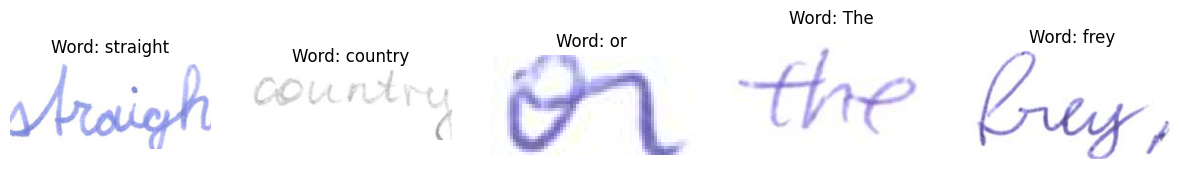

In [13]:
def display_random_images(train,path, num_images=5):

    random_indices = random.sample(range(len(train)), num_images)

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(random_indices):

        image_path = path +train.at[idx, 'Image Path']
        word_of_image = train.at[idx, 'Word']
        image = cv2.imread(image_path)

        # Create a subplot for each image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f'Word: {word_of_image}')
        plt.axis('off')

    plt.show()


display_random_images(train,"/content/train/", num_images=5)

In [14]:
# Define the characters you want to support, including uppercase, lowercase, and digits
alphabets = string.ascii_letters + string.digits + " ' -"

max_str_len = 24  # max length of input labels
num_of_characters = len(alphabets) + 1
num_of_timestamps = 64  # max length of predicted labels: 64
batch_size = 512

def encode_and_pad_strings(text):
    # Initialize an empty list to store the encoded values for the string
    # Encoding each output word into digits
    dig_list = []
    for char in str(text):
        idx = alphabets.find(char)
        dig_list.append(idx if idx != -1 else alphabets.find('-'))

    return pad_sequences([dig_list], maxlen=max_str_len, padding='post', value=-1)[0]

# Example usage
input_string = "A9ello world"
result = encode_and_pad_strings(input_string)
print(result)

[26 61  4 11 11 14 62 22 14 17 11  3 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [15]:
def decode_padded_sequence(padded_sequence):
    text = ''
    for number in padded_sequence:
        if number == -1: # CTC blank
            break
        else:
            text += alphabets[number]

    return text

# Example usage
input_string = "Hello world"
encoded_result = encode_and_pad_strings(input_string)
print("Encoded Sequence:", encoded_result)

decoded_result = decode_padded_sequence(encoded_result)
print("Decoded String:", decoded_result)

Encoded Sequence: [33  4 11 11 14 62 22 14 17 11  3 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Decoded String: Hello world


In [16]:
num_of_timestamps = 64
@tf.function

def salt_and_pepper_noise(image, salt_prob=0.02, pepper_prob=0.02):

    salt_mask = tf.random.uniform(shape=tf.shape(image), minval=0, maxval=1) < salt_prob
    image = tf.where(salt_mask, 1.0, image)
    pepper_mask = tf.random.uniform(shape=tf.shape(image), minval=0, maxval=1) < pepper_prob
    image = tf.where(pepper_mask, 0.0, image)

    return image

def preprocess_image(image_path , label, label_len):
    target_height = 64
    target_width = 256

    file = tf.io.read_file(image_path)
    image = tf.image.decode_png(file, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)

    original_height = tf.shape(image)[0]
    original_width = tf.shape(image)[1]
    aspect_ratio = tf.cast(original_width, tf.float32) / tf.cast(original_height, tf.float32)

    new_width = tf.cast(target_height, tf.float32) * aspect_ratio

    image = tf.image.resize(image, [target_height, target_width])
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, max_delta=0.8)



    image = salt_and_pepper_noise(image, salt_prob=0.02, pepper_prob=0.02)

    image = (image - tf.reduce_mean(image)) / tf.math.reduce_std(image)

    image = tf.clip_by_value(image, 0.0, 1.0)

    input_len = [num_of_timestamps - 2]

    return image, label, input_len, label_len, [0]

In [17]:
def create_data_list(dataset, img_dir):
    data_x, data_y, label_len = [], [], []
    for idx, row in dataset.iterrows():
        if isinstance(row['Word'], str):
            text = row['Word']
            label_len.append(len(text))
            data_y.append(encode_and_pad_strings(text))
            data_x.append(os.path.join(img_dir, row['Image Path']))

    return data_x, data_y, label_len

In [18]:
train_img_dir = "/content/train"
val_img_dir = "/content/val"
batch_size = 512


AUTOTUNE = tf.data.experimental.AUTOTUNE

def create_tf_dataset(data_x, data_y, label_len):
    batch_size = 512
    data_xx = tf.constant(data_x, dtype=tf.string)
    data_yy = tf.constant(data_y, dtype=tf.int64)
    label_lenn = tf.constant(label_len, dtype=tf.int64)
    dataset = tf.data.Dataset.from_tensor_slices((data_xx, data_yy, label_lenn))
    dataset = dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE).batch(batch_size)
    dataset = dataset.map(lambda *x: (x[0:-1],x[-1])).prefetch(AUTOTUNE).prefetch(buffer_size=AUTOTUNE)
    return dataset


train_x, train_y, train_label_len = create_data_list(train,train_img_dir)
train_dataset = create_tf_dataset(train_x, train_y, train_label_len)

val_x, val_y, val_label_len = create_data_list(val,val_img_dir)
val_dataset = create_tf_dataset(val_x, val_y, val_label_len)

print(len(train_y), len(val_y))

89913 4995


In [19]:
# Defining the CTC loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args

    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


# Define the Convolutional Block
def conv_block(num_filters, use_max_pool=True, pool_size=(4, 2), stride=2):
    cnn = Sequential()
    cnn.add(Conv2D(num_filters, (3, 3), activation="relu", padding="same"))
    cnn.add(BatchNormalization())
    cnn.add(MaxPool2D(pool_size=pool_size, strides=stride))
    return cnn

# Define the CRNN Model
def CRNN():
    # Inputs
    inputs = Input(shape=(64, 256, 1), name='image')
    labels = Input(name="label", shape=(None,), dtype="float32")
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')

    # CNN
    conv1 = conv_block(32)(inputs)
    conv2 = conv_block(64)(conv1)
    conv3 = conv_block(128, pool_size=(4, 1), stride=1)(conv2)
    conv4 = conv_block(256, pool_size=(4, 1), stride=1)(conv3)
    conv5 = conv_block(128, pool_size=(5, 1), stride=1)(conv4)

    # CNN --> RNN
    reshape = Reshape((num_of_timestamps, 512))(conv5)
    dense = Dense(num_of_timestamps, activation='relu')(reshape)
    bn = BatchNormalization()(dense)
    dropout = Dropout(0.2)(bn)

    # RNN
    lstm1 = Bidirectional(LSTM(64, return_sequences=True, dropout = 0.2))(dropout)
    lstm2 = Bidirectional(LSTM(64, return_sequences=True, dropout = 0.2))(lstm1)

    attention = Attention()([lstm2, lstm1])
    merged = concatenate([lstm2, attention])



    # Outputs
    y_pred = Dense(num_of_characters, activation = 'softmax')(merged)
    ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

    pred_model = Model(inputs=inputs, outputs=y_pred)
    train_model = Model(inputs=[inputs, labels, input_length, label_length], outputs=ctc_loss)

    return pred_model, train_model

model, train_model = CRNN()
train_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 64, 256, 1)]         0         []                            
                                                                                                  
 sequential (Sequential)     (None, 31, 128, 32)          448       ['image[0][0]']               
                                                                                                  
 sequential_1 (Sequential)   (None, 14, 64, 64)           18752     ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 11, 64, 128)          74368     ['sequential_1[0][0]']        
                                                                                            

In [20]:
train_model.compile(loss={'ctc': lambda y_true, y_pred: y_pred},
                    optimizer=Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, clipnorm=1.0))

filepath = "best_model.h5"

# function callback
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor= 'val_loss',
                             verbose=1, save_best_only=True, save_weights_only=True, mode='auto')

earlyStopping = EarlyStopping(monitor='val_loss', mode='auto', patience=30)
callbacks_list = [checkpoint, earlyStopping]

# method 1
history = train_model.fit(train_dataset,
                          epochs=100,
                          validation_data=val_dataset,
                          verbose = 1,
                          shuffle=True,
                          callbacks=callbacks_list)
model.save('my_model.keras')
# Save the model
#model.save('my_model.h5')

Epoch 1/100
176/176 [==============================] - ETA: 0s - loss: 16.7541
Epoch 1: val_loss improved from inf to 25.49643, saving model to best_model.h5
176/176 [==============================] - 84s 340ms/step - loss: 16.7541 - val_loss: 25.4964
Epoch 2/100
176/176 [==============================] - ETA: 0s - loss: 8.4712
Epoch 2: val_loss improved from 25.49643 to 24.62140, saving model to best_model.h5
176/176 [==============================] - 55s 314ms/step - loss: 8.4712 - val_loss: 24.6214
Epoch 3/100
176/176 [==============================] - ETA: 0s - loss: 4.6797
Epoch 3: val_loss improved from 24.62140 to 5.78834, saving model to best_model.h5
176/176 [==============================] - 56s 315ms/step - loss: 4.6797 - val_loss: 5.7883
Epoch 4/100
176/176 [==============================] - ETA: 0s - loss: 2.9983
Epoch 4: val_loss improved from 5.78834 to 3.56511, saving model to best_model.h5
176/176 [==============================] - 55s 314ms/step - loss: 2.9983 - val_l

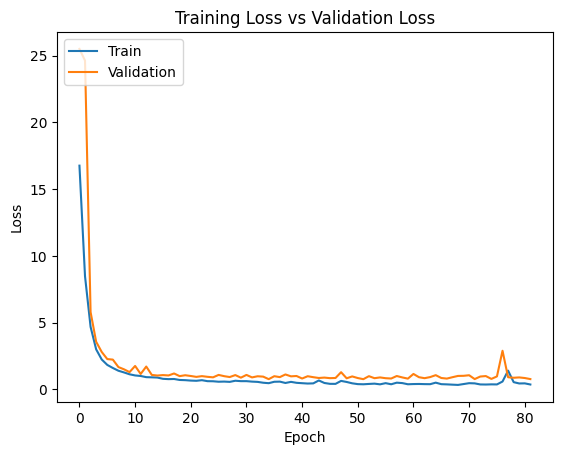

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [22]:
model.load_weights('/content/best_model.h5')

In [23]:
def ctc_decoder(predictions):
    '''
    input: given batch of predictions from text rec model
    output: return lists of raw extracted text

    '''
    text_list = []

    pred_indices = np.argmax(predictions, axis=2)

    for i in range(pred_indices.shape[0]):
        ans = ""

        ## merge repeats
        merged_list = [k for k,_ in groupby(pred_indices[i])]

        ## remove blanks
        for p in merged_list:
            if p != len(alphabets):
                ans += alphabets[int(p)]

        text_list.append(ans)

    return text_list

In [24]:
def get_predictions_and_labels(dataset, model):
    """
    Input: Tensorflow Dataset and the model to predict
    Output: Extract labels from dataset and get prediction from the model
    """
    predictions, labels = [], []
    for batch in dataset.as_numpy_iterator():
        images, num_labels = batch[0][0], batch[0][1]
        preds = model.predict(images)
        predictions.extend(ctc_decoder(preds))
        labels.extend([decode_padded_sequence(num_labels[i]) for i in range(len(num_labels))])

    return predictions, labels

predictions, labels = get_predictions_and_labels(val_dataset, model)
print(len(predictions), len(labels))

13/13 [==============================] - 2s 16ms/step
4995 4995


In [25]:
def get_accuracy_characters_and_words(predictions, labels):
    """
    Input: The predictions and labels text of validation data
    Output: The accuracy about words and characters
    """
    word_accuracy = np.mean([predictions[i] == labels[i] for i in range(len(predictions))])
    num_correct_char, len_char = 0, 0
    for i in range(len(predictions)):
        num_correct_char += np.sum([predictions[i][j] == labels[i][j] for j in range(min(len(predictions[i]), len(labels[i])))])
        len_char += len(labels[i])

    character_accuracy = num_correct_char/ float(len_char)
    return word_accuracy, character_accuracy

word_accuracy, character_accuracy = get_accuracy_characters_and_words(predictions, labels)
print('Character accuracy in the validation set: {} %'.format(round(character_accuracy * 100, 3)))
print('Word accuracy in the validation set: {} %'.format(round(word_accuracy * 100, 3)))

Character accuracy in the validation set: 95.239 %
Word accuracy in the validation set: 90.25 %


In [26]:
!pip install python-Levenshtein


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 23.0 MB/s eta 0:00:00


In [33]:
import Levenshtein

def word_error_rate(predictions, labels):
    total_errors = 0
    total_words = 0
    for pred, label in zip(predictions, labels):
        total_errors += Levenshtein.distance(pred.split(), label.split())
        total_words += len(label.split())

    wer = total_errors / total_words
    return wer

def character_error_rate(predictions, labels):
    total_errors = 0
    total_characters = 0
    for pred, label in zip(predictions, labels):
        total_errors += sum(1 for a, b in zip(pred, label) if a != b)
        total_characters += len(label)

    cer = total_errors / total_characters
    return cer

wer = word_error_rate(predictions, labels)
cer = character_error_rate(predictions, labels)

print(f"Word Error Rate (WER): {wer * 100:.2f}")
print(f"Character Error Rate (CER): {cer * 100:.2f}")

Word Error Rate (WER): 9.75
Character Error Rate (CER): 3.98


In [28]:
# Declare image directory and label csv file for the test dataset
test_img_dir = '/content/test'

# Create test dataset with TensorFlow format
test_x, test_y, test_label_len = create_data_list(test, test_img_dir)
test_dataset = create_tf_dataset(test_x, test_y, test_label_len)

16/16 [==============================] - 0s 10ms/step


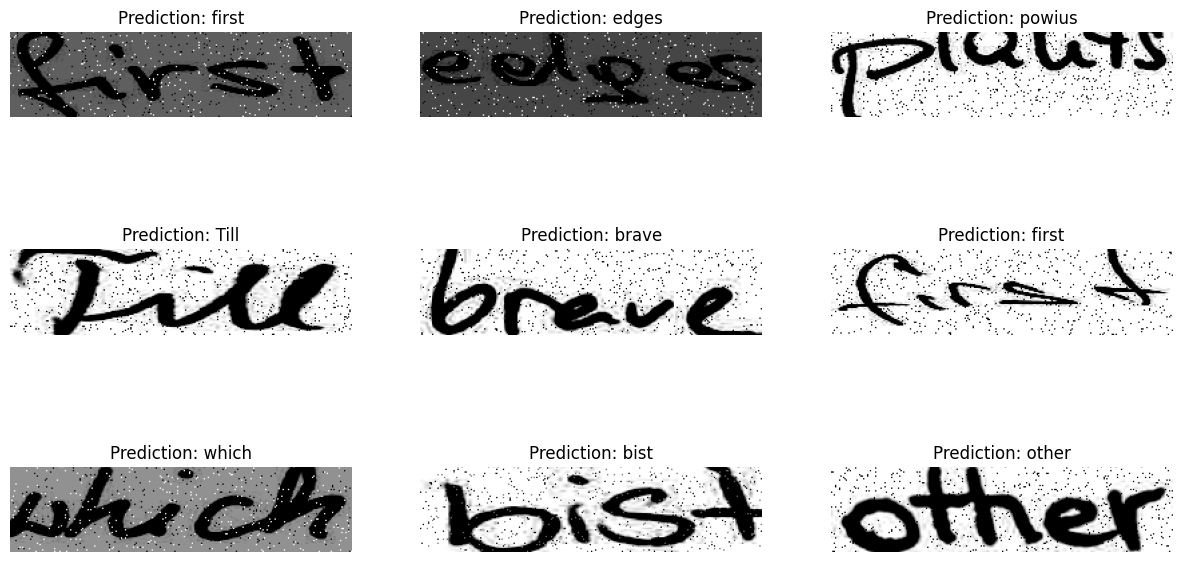

In [29]:
def test_images_data_with_model_prediction(model, dataset):
    # Create predictions for a batch in this dataset
    for batch in dataset.as_numpy_iterator():
        images = batch[0][0]
        predictions = ctc_decoder(model.predict(images))
        break

    # Set up the plot
    fig, axs = plt.subplots(3, 3, figsize=(15, 8))

    # Loop over the random images and plot the image with prediction model
    for i in range(9):
        row = i // 3
        col = i % 3

        idx = random.randint(0, batch_size)
        axs[row, col].imshow(images[idx], cmap = 'gray')
        axs[row, col].set_title('Prediction: {}'.format(predictions[idx]), fontsize=12)
        axs[row, col].axis('off')
    plt.show()

test_images_data_with_model_prediction(model, test_dataset)

In [30]:
predictionst, labelst = get_predictions_and_labels(test_dataset, model)
print(len(predictionst), len(labelst))

13/13 [==============================] - 0s 9ms/step
4995 4995


In [34]:
wer = word_error_rate(predictionst, labelst)
cer = character_error_rate(predictionst, labelst)

print(f"Word Error Rate (WER) Test: {wer * 100:.2f}")
print(f"Character Error Rate (CER) Test: {cer * 100:.2f}")

Word Error Rate (WER) Test: 10.77
Character Error Rate (CER) Test: 4.15


In [32]:
word_accuracyt, character_accuracyt = get_accuracy_characters_and_words(predictionst, labelst)
print('Character accuracy in the Test set: {} %'.format(round(character_accuracyt * 100, 3)))
print('Word accuracy in the Test set: {} %'.format(round(word_accuracyt * 100, 3)))

Character accuracy in the Test set: 95.065 %
Word accuracy in the Test set: 89.229 %
